In [64]:
import numpy as np 
import random
from scipy.optimize import minimize
from sphere_decoding.sphereDecodingUseC import sphere_decoding_BER
import matplotlib.pyplot as plt
from timeit import default_timer as time

# 交叉熵正常训练

Nt = 2
Nr = 4

iter_num = 30
channel_list = np.load("channel_list_4_2.npy")
H_list = channel_list[0:iter_num]

SNR_list = np.array([25])


alpha = 0.1

max_iter = 1000

pilot_length = 128

beta1 = 0

SD_mean_performance = np.zeros(len(SNR_list))
QNN_mean_performance_128 = np.zeros(len(SNR_list))

save_loss = np.empty((len(SNR_list), iter_num))
save_BER = np.empty((len(SNR_list), iter_num))
save_channel = np.empty((len(SNR_list), iter_num, Nr, Nt), dtype=np.complex128)

In [62]:
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = [np.array([qam16_modulation(bits_sequence[i+j]) for j in range(Nt)]) for i in range(0, len(bits_sequence), Nt)]
    return bits_sequence, x_sequence

def generate_noise(SNR, Nr):
    return np.sqrt(1/(2*SNR))*(np.random.randn(Nr,1)+1j*np.random.randn(Nr,1))

def generate_data(Nr,Nt,SNR_dB,length,H_channel):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    SNR= 10**(SNR_dB/10)
    n_sequence = [generate_noise(SNR, Nr) for i in range(length)]
    y_sequence = [(np.dot(H_channel, x_sequence[i].reshape(Nt,1)) + n_sequence[i])*np.sqrt(SNR) for i in range(length)]
    
    return bits_sequence, x_sequence, y_sequence

In [40]:
def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)

def calculate_layer1(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    output = np.zeros(dimension_layer1)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        s_conjugate_transpose = s.conj().T
        error = y - np.dot(H_hat,s)
        value =  np.square(np.linalg.norm(error))
        output[index] = value
    return output

def calculate_max_log(H_hat, y):
    a = calculate_layer1(H_hat, y)
    llr0 = np.ones(4*Nt)*1e50
    llr1 = np.ones(4*Nt)*1e50
    for index in range(len(a)):
        bit_index = str(bin(index)[2:].zfill(4*Nt))
        value = a[index]
        for ii in range(4*Nt):
            bit = bit_index[ii]
            if bit == '0':
                if value < llr0[ii]:
                    llr0[ii] = value
            if bit == '1':
                if value < llr1[ii]:
                    llr1[ii] = value
    detect_result = ''
    for ii in range(4*Nt):
        if llr0[ii] - llr1[ii]>0:
            detect_result += '1'
        else:
            detect_result += '0'
    return detect_result

def count_differences(str1, str2):
    return sum(a != b for a, b in zip(str1, str2))

def calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing):
    error = 0
    for ii in range(len(y_sequence_testing)):
        detect_result = calculate_max_log(H_trained, y_sequence_testing[ii])
        true_sequence = ''.join(bits_sequence_testing[ii*Nt+jj] for jj in range(Nt))
        error += count_differences(detect_result, true_sequence)
    BER = error/(len(y_sequence_testing)*len(detect_result))
    return BER


In [65]:

for ii in range(len(SNR_list)):
    SNR_dB = SNR_list[ii]
    SNR = 10**(SNR_dB/10)
    
    SD_performance = np.zeros(iter_num)
    QNN_performance_128 = np.zeros(iter_num)

    for jj in range(iter_num):
        print("----------------------------current SNR_dB: " +str(SNR_dB))
        print("----------------------------current iter num: " +str(jj))

        H = H_list[jj]

        bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,SNR_dB,1024,H)
        SD_performance[jj] = sphere_decoding_BER(H, y_sequence_testing, bits_sequence_testing, 1)
        print("SD: "+str(SD_performance[jj]))
        
        
        H_w = np.sqrt(SNR)*H
        BER = calculate_BER(H_w, bits_sequence_testing, y_sequence_testing)

        save_BER[ii][jj] = BER

        QNN_performance_128[jj] = BER
        print("QNN: "+str(BER))

    SD_mean_performance[ii] = np.mean(SD_performance)
    QNN_mean_performance_128[ii] = np.mean(QNN_performance_128)

----------------------------current SNR_dB: 25
----------------------------current iter num: 0
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 1
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 2
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 3
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 4
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 5
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 6
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 7
SD: 0.0
QNN: 0.0
----------------------------current SNR_dB: 25
----------------------------current iter num: 8
SD: 0.0
Q

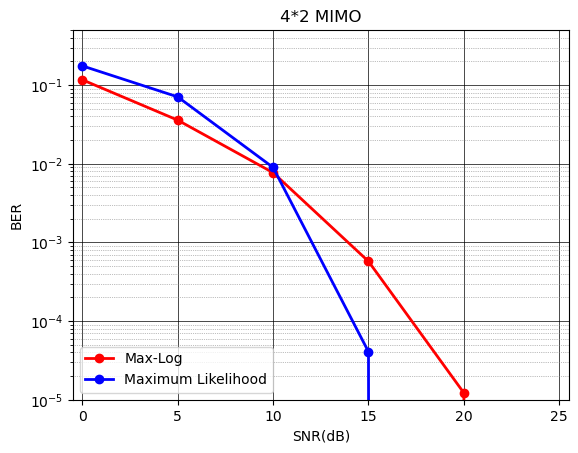

In [60]:
import matplotlib.ticker as ticker

fig = plt.figure()

ax1 = fig.add_subplot(111)

lns1 = ax1.plot(SNR_list, SD_mean_performance, '-ro', linewidth=2.0, label="Max-Log")
lns2 = ax1.plot(SNR_list, QNN_mean_performance_128, '-bo', linewidth=2.0, label="Maximum Likelihood")



lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto'))
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

ax1.set_xticks(SNR_list)
ax1.set_yscale("log")
ax1.set_adjustable("datalim")
ax1.set_xlim(-0.5,25.5)
ax1.set_ylim(1e-5, 0.5)
ax1.set_ylabel("BER")
ax1.set_xlabel("SNR(dB)")
plt.title(r"4*2 MIMO")

# plt.savefig('BER.png',dpi=600, bbox_inches='tight')
plt.show()

In [46]:
error = np.array([[1+1j],[1-1j]])

In [48]:
np.square(np.linalg.norm(error))

4.0